In [1]:
###Required packages
import numpy as np
from hyperopt import hp, fmin, tpe
from scikits.odes.ode import ode
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [ ]:
## Glucaric Acid Synthesis Model

### Model Specification

In [3]:
###Color palette
orders = ['Open Loop', 'Upstream Repression', 'Downstream Activation', 'Dual Control']
palette = {'Open Loop': sns.color_palette()[3], 'Upstream Repression': 'tab:orange', 'Downstream Activation': 'tab:green', 'Dual Control': 'tab:blue', 'Initial':'black'}

###Helper functions
def michaelismenten(x, vm, km):
    return (vm*x)/(km+x)

def reversible_michaelismenten(x, y, vm, keq, kmx, kmy):
    return (vm*(x - (y/keq)))/(x + kmx*(1+(y/kmy)))

def hilleqn(x, vm, n, km):
    return (vm*x**n)/(km**n + x**n)

def michaelismenten_substrateactivation(x, vm, km, a, ka):
    vm_eff = vm * (1+ (a*x)/(ka + x))
    return (vm_eff*x)/(km  + x)

def activation(x, k, theta, n):
    return (k*x**n)/(theta**n + x**n)
    
def repression(x, k, theta, n):
    return (k*theta**n)/(theta**n + x**n)
    
def loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2):
    loss = alpha1*j1 + alpha2*j2
    return j1, j2, loss

def name_converter(A):
    if A == ((0, 1, 0), (1, 0, 0)):
        return 'Dual Control'

    elif A == ((0, 0, 1), (0, 0, 1)):
        return 'Open Loop'

    elif A == ((0, 0, 1), (1, 0, 0)):
        return 'Downstream Activation'

    elif A == ((0, 1, 0), (0, 0, 1)):
        return 'Upstream Repression'
    else: return 'Invalid Circuit'

###Model definition
def glucaric_acid(t, y, ydot, params):

    lam = 2.7778E-05
    v_pts = 0.1656
    vm_pgi = 0.8751
    keq_pgi = 0.3
    km_pgi_g6p = 0.28
    km_pgi_f6p = 0.147
    vm_zwf = 0.0853
    km_zwf_g6p = 0.1
    vm_pfk = 2.615
    km_pfk_f6p = 0.16
    n_pfk = 3
    vm_ino1 = 0.2616
    km_ino1_g6p = 1.18
    vm_t_mi = 0.045
    km_t_mi = 15
    vm_miox = 0.2201
    km_miox_mi = 24.7
    a_miox = 5.4222
    ka_miox_mi = 20


    g6p, f6p, mi, ino1, miox, j1, j2 = y

    A, W = params 

    n_ino1, theta_ino1, k_ino1 = W[0]
    n_miox, theta_miox, k_miox = W[1]

    v_pgi = reversible_michaelismenten(g6p, f6p, vm_pgi, keq_pgi, km_pgi_g6p, km_pgi_f6p)
    v_zwf = michaelismenten(g6p, vm_zwf, km_zwf_g6p)
    v_pfk = hilleqn(f6p, vm_pfk, n_pfk, km_pfk_f6p)
    v_ino1 = ino1 * michaelismenten(g6p, vm_ino1, km_ino1_g6p)
    v_tm = michaelismenten(mi, vm_t_mi, km_t_mi)
    v_miox = miox * michaelismenten_substrateactivation(mi, vm_miox, km_miox_mi, a_miox, ka_miox_mi)

    u_ino1_mi = np.sum(A[0]*np.array([activation(mi, k_ino1, theta_ino1, n_ino1), repression(mi, k_ino1, theta_ino1, n_ino1), k_ino1]))
    u_miox_mi = np.sum(A[1]*np.array([activation(mi, k_miox, theta_miox, n_miox), repression(mi, k_miox, theta_miox, n_miox), k_miox]))

    ydot[0] = v_pts - v_zwf - v_pgi - lam*g6p
    ydot[1] = v_pgi + 0.5*v_zwf - v_pfk - lam*f6p
    ydot[2] = v_ino1 - v_tm - v_miox - lam*mi
    ydot[3] = u_ino1_mi  - lam*ino1
    ydot[4] = u_miox_mi - lam*miox
    ydot[5] = (v_pts - v_miox)**2
    ydot[6] = u_ino1_mi + u_miox_mi

###Define search space
space = hp.choice('architecture', 
    [([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 1E-7, 10), hp.uniform('k1_da', 1E-7, 5)], [2., hp.uniform('theta2_da', 1E-7, 10), hp.uniform('k2_da', 1E-7, 5)]]),
     ([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 1E-7, 10), hp.uniform('k1_ur', 1E-7, 5)], [2., hp.uniform('theta2_ur', 1E-7, 10), hp.uniform('k2_ur', 1E-7, 5)]]),
     ([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 1E-7, 10), hp.uniform('k1_nc', 1E-7, 5)], [2., hp.uniform('theta2_nc', 1E-7, 10), hp.uniform('k2_nc', 1E-7, 5)]]),
     ([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 1E-7, 10), hp.uniform('k1_dc', 1E-7, 5)], [2., hp.uniform('theta2_dc', 1E-7, 10), hp.uniform('k2_dc', 1E-7, 5)]])])

###Objective function
def run_hyperopt(max_iters):
    losses = []
    params = []
    circuits = []

    #Define objective function
    def objective(args):
        architecture, param_values = args
        #Integration conditions
        t = np.linspace(0, 5E5, 200) 
        y0 = np.array([0.281, 0.0605, 0., 0., 0. , 0., 0.]) #g6p, f6p, mi, ino1, miox

        extra_options = {'old_api': False, 'user_data': [architecture, param_values], 'rtol':1E-4}
        ode_solver = ode('cvode', glucaric_acid, **extra_options)
        solution = ode_solver.solve(t, y0)
        j1, j2 = solution.values.y[-1, -2:]
        j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-3)
        losses.append(loss)
        params.append(param_values)
        circuits.append(architecture)
        return loss
    

    #Run hyperopt call
    best = fmin(objective, space, algo=tpe.suggest, max_evals=max_iters)
    #Create trajectory data frame
    landscape = pd.DataFrame({'circuit':circuits, 'loss': losses, 'k1': [params[i][0][2] for i in range(len(params))], 'k2': [params[i][1][2] for i in range(len(params))], 'theta1': [params[i][0][1] for i in range(len(params))], 'theta2': [params[i][1][1] for i in range(len(params))]})  
    landscape['Circuit'] = [name_converter(landscape.circuit[i]) for i in range(len(landscape))]
    landscape = landscape.reset_index()

    best_loss = 1E5
    best_circuit = 'Initial'
    best_losses = []
    best_losses_circuits = []
    for i in range(len(landscape)):
        if landscape.loss[i] < best_loss:
            best_loss = landscape.loss[i]
            best_circuit = landscape.Circuit[i]
        best_losses.append(best_loss)
        best_losses_circuits.append(best_circuit)
    landscape['best_losses'] = best_losses
    landscape['best_loss_circuit'] = best_losses_circuits

    return landscape, best

### Simulation Experiments

In [ ]:
###Run sample optimization
max_iters = 10
landscape, best = run_hyperopt(max_iters)
#landscape.to_csv('sample_run.csv')

In [ ]:
###Explore kinetic perturbations - 4 architecture version
global perturbs
perturbs_total = pd.read_csv('kinetic_perturbation_total.csv')
p1s = perturbs_total.perturb1.unique()[399:]
p2s =  perturbs_total.perturb2.unique()[399:]
p3s = perturbs_total.perturb3.unique()[399:]

total_landscape =  pd.DataFrame()
for p1, p2, p3 in zip(p1s, p2s, p3s):
    perturbs = [p1, p2, p3]
    landscape, best = run_hyperopt(1000)
    total_landscape = pd.concat([total_landscape, landscape])
    landscape.to_csv('kinetic_perturbation_4arch_backup3.csv', mode='a')
total_landscape.to_csv('kinetic_perturbation_4arch2.csv')

In [ ]:
###Explore kinetic perturbations - VERY TIME CONSUMING
global perturbs
max_iters = 1000
total_landscape =  pd.DataFrame()
total_perturbs = lhs(3, samples=1000)
for p in total_perturbs:
    perturbs = p
    space = hp.choice('architecture', 
    [([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 1E-7, 10), hp.uniform('k1_da', 1E-7, 5)], [2., hp.uniform('theta2_da', 1E-7, 10), hp.uniform('k2_da', 1E-7, 5)]])])
    da_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 1E-7, 10), hp.uniform('k1_ur', 1E-7, 5)], [2., hp.uniform('theta2_ur', 1E-7, 10), hp.uniform('k2_ur', 1E-7, 5)]])])
    ur_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 1E-7, 10), hp.uniform('k1_nc', 1E-7, 5)], [2., hp.uniform('theta2_nc', 1E-7, 10), hp.uniform('k2_nc', 1E-7, 5)]])])
    nc_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 1E-7, 10), hp.uniform('k1_dc', 1E-7, 5)], [2., hp.uniform('theta2_dc', 1E-7, 10), hp.uniform('k2_dc', 1E-7, 5)]])])
    dc_landscape, best = run_hyperopt(max_iters)

    landscape = pd.concat([dc_landscape, nc_landscape, ur_landscape, da_landscape])
    total_landscape = pd.concat([total_landscape, landscape])
    landscape.to_csv('kinetic_perturbation.csv', mode='a')
    
total_landscape.to_csv('kinetic_perturbation_total.csv')

In [ ]:
###Explore growth conditions robustness 
global perturbs
max_iters = 1000
total_landscape = pd.DataFrame()
total_perturbs = lhs(2, samples=500)
for p in total_perturbs:
    perturbs = p
    space = hp.choice('architecture', 
    [([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 1E-7, 10), hp.uniform('k1_ur', 1E-7, 5)], [2., hp.uniform('theta2_ur', 1E-7, 10), hp.uniform('k2_ur', 1E-7, 5)]])])
    ur_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 1E-7, 10), hp.uniform('k1_da', 1E-7, 5)], [2., hp.uniform('theta2_da', 1E-7, 10), hp.uniform('k2_da', 1E-7, 5)]])])
    da_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 1E-7, 10), hp.uniform('k1_dc', 1E-7, 5)], [2., hp.uniform('theta2_dc', 1E-7, 10), hp.uniform('k2_dc', 1E-7, 5)]])])
    dc_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 1E-7, 10), hp.uniform('k1_nc', 1E-7, 5)], [2., hp.uniform('theta2_nc', 1E-7, 10), hp.uniform('k2_nc', 1E-7, 5)]])])
    nc_landscape, best = run_hyperopt(max_iters)

    landscape = pd.concat([ur_landscape, da_landscape, dc_landscape, nc_landscape])
    landscape['perturb0'] = p[0]
    landscape['perturb1'] = p[1]
    landscape.to_csv('growth_condition_robustness1.csv', mode='a', header=False)
    total_landscape = pd.concat([total_landscape, landscape])

total_landscape.to_csv('growth_conditions_robustness_backup1.csv')

In [ ]:
###Explore growth conditions robustness - 1D sweep
global perturbs
max_iters = 1000
total_landscape = pd.DataFrame()
total_perturbs = np.linspace(0.5, 2, 101)
for p in total_perturbs:
    perturbs = [p, 1.]
    space = hp.choice('architecture', 
    [([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 1E-7, 10), hp.uniform('k1_ur', 1E-7, 5)], [2., hp.uniform('theta2_ur', 1E-7, 10), hp.uniform('k2_ur', 1E-7, 5)]])])
    ur_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 1E-7, 10), hp.uniform('k1_da', 1E-7, 5)], [2., hp.uniform('theta2_da', 1E-7, 10), hp.uniform('k2_da', 1E-7, 5)]])])
    da_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 1E-7, 10), hp.uniform('k1_dc', 1E-7, 5)], [2., hp.uniform('theta2_dc', 1E-7, 10), hp.uniform('k2_dc', 1E-7, 5)]])])
    dc_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 1E-7, 10), hp.uniform('k1_nc', 1E-7, 5)], [2., hp.uniform('theta2_nc', 1E-7, 10), hp.uniform('k2_nc', 1E-7, 5)]])])
    nc_landscape, best = run_hyperopt(max_iters)

    landscape = pd.concat([ur_landscape, da_landscape, dc_landscape, nc_landscape])
    landscape['perturbation'] = p
    landscape.to_csv('gc_influx.csv', mode='a', header=False)
    total_landscape = pd.concat([total_landscape, landscape])

total_landscape.to_csv('gc_influx_total.csv')

In [ ]:
###Explore growth conditions robustness - 1D sweep
global perturbs
max_iters = 1000
total_landscape = pd.DataFrame()
total_perturbs = np.linspace(0.5, 2, 101)
for p in total_perturbs:
    perturbs = [1., p]
    space = hp.choice('architecture', 
    [([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 1E-7, 10), hp.uniform('k1_ur', 1E-7, 5)], [2., hp.uniform('theta2_ur', 1E-7, 10), hp.uniform('k2_ur', 1E-7, 5)]])])
    ur_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 1E-7, 10), hp.uniform('k1_da', 1E-7, 5)], [2., hp.uniform('theta2_da', 1E-7, 10), hp.uniform('k2_da', 1E-7, 5)]])])
    da_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 1E-7, 10), hp.uniform('k1_dc', 1E-7, 5)], [2., hp.uniform('theta2_dc', 1E-7, 10), hp.uniform('k2_dc', 1E-7, 5)]])])
    dc_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 1E-7, 10), hp.uniform('k1_nc', 1E-7, 5)], [2., hp.uniform('theta2_nc', 1E-7, 10), hp.uniform('k2_nc', 1E-7, 5)]])])
    nc_landscape, best = run_hyperopt(max_iters)

    landscape = pd.concat([ur_landscape, da_landscape, dc_landscape, nc_landscape])
    landscape['perturbation'] = p
    landscape.to_csv('gc_export.csv', mode='a', header=False)
    total_landscape = pd.concat([total_landscape, landscape])

total_landscape.to_csv('gc_export_total.csv')

In [ ]:
###Run hyperopt 100 times to solve for background
max_iters = 1000
total_background =  pd.DataFrame()
perturbs = [1., 1., 1.]
for i in range(100):
    space = hp.choice('architecture', 
    [([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 1E-7, 10), hp.uniform('k1_da', 1E-7, 5)], [2., hp.uniform('theta2_da', 1E-7, 10), hp.uniform('k2_da', 1E-7, 5)]])])
    da_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 1E-7, 10), hp.uniform('k1_ur', 1E-7, 5)], [2., hp.uniform('theta2_ur', 1E-7, 10), hp.uniform('k2_ur', 1E-7, 5)]])])
    ur_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 1E-7, 10), hp.uniform('k1_nc', 1E-7, 5)], [2., hp.uniform('theta2_nc', 1E-7, 10), hp.uniform('k2_nc', 1E-7, 5)]])])
    nc_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 1E-7, 10), hp.uniform('k1_dc', 1E-7, 5)], [2., hp.uniform('theta2_dc', 1E-7, 10), hp.uniform('k2_dc', 1E-7, 5)]])])
    dc_landscape, best = run_hyperopt(max_iters)

    background = pd.concat([dc_landscape, nc_landscape, ur_landscape, da_landscape])
    total_background = pd.concat([total_background, background])
    #background.to_csv('background.csv', mode='a')
    
total_background.to_csv('background_total.csv')

In [ ]:
###Run hyperopt 100 times with 4 architectures to get 4arch background
total_background =  pd.DataFrame()
perturbs = [1., 1., 1.]
for i in range(100):
    landscape, best = run_hyperopt(1000)
    total_background = pd.concat([total_landscape, landscape])
    landscape.to_csv('background_4arch_backup.csv', mode='a')
total_landscape.to_csv('background_4arch.csv')

### Visualization

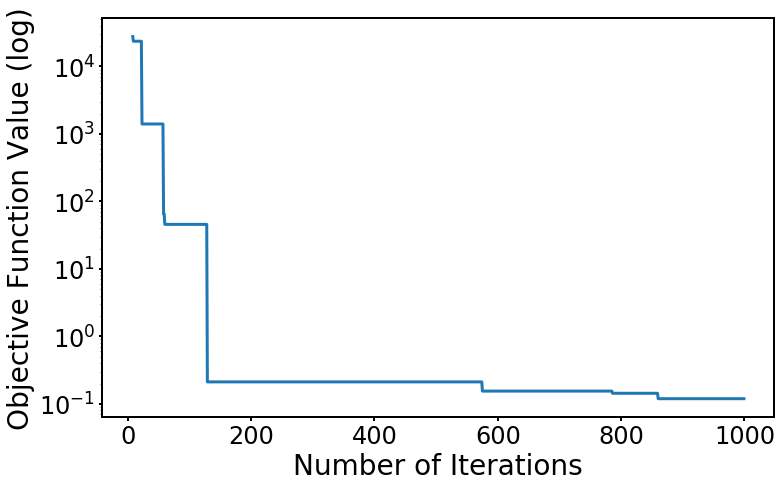

In [34]:
####FIGURE: Sample loss descent
landscape = pd.read_csv('sample_run.csv')
fig, ax = plt.subplots(1,1,figsize=(11, 7))
prev_c = 'Initial'
starts = []
archs = [prev_c]
for i in range(len(landscape)):
    c = landscape.best_loss_circuit[i]
    if c != prev_c: 
        starts.append(i)
        archs.append(c)
        prev_c = c
starts
stops = starts[1:]
stops.append(len(landscape))

for start, stop, a in zip(starts, stops, archs[1:]):
    ax.plot(landscape.index[start:stop+1], landscape.best_losses[start:stop+1], color=palette[a], linewidth=3)
ax.set_ylabel('Objective Function Value (log)', fontsize=28)
ax.set_yscale('log')
ax.set_xlabel('Number of Iterations', fontsize=28)

ax.tick_params(axis='y', labelsize=24)
ax.tick_params(axis='x', labelsize=24)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(width=2)

fig.tight_layout()
fig.savefig('sample_loss_descent.png', dpi=300)

/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/matplotlib/transforms.py:740: UserWarning: Warning: converting a masked element to nan.
  points = np.asarray(points, float)
/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


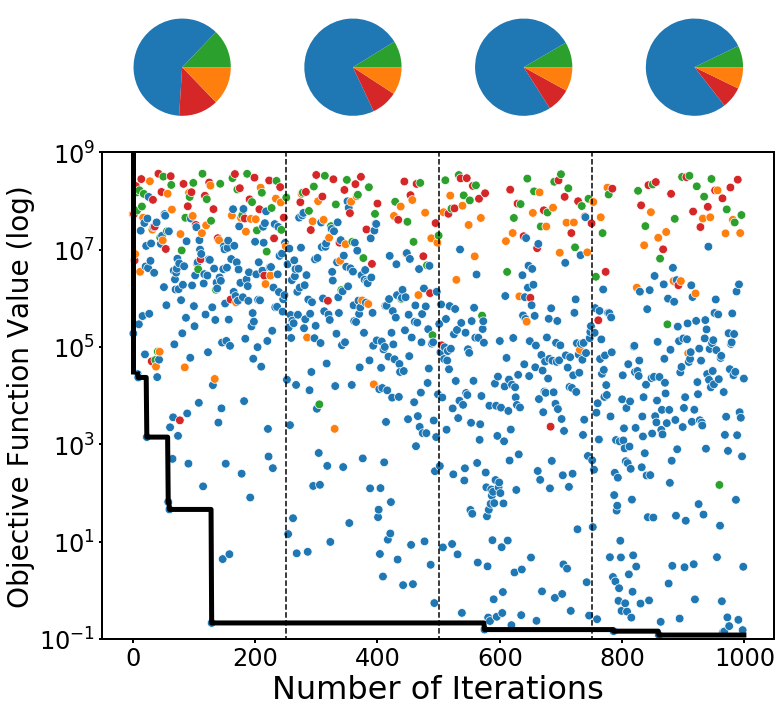

In [70]:
####FIGURE: Sample loss scatter and pie
fig = plt.figure(figsize=(11, 10))
gs = gridspec.GridSpec(nrows=2, ncols=4, height_ratios=[1, 4], width_ratios=[1, 1, 1, 1])

ax = fig.add_subplot(gs[1, :])
ax.set_xlabel('Number of Iterations', fontsize=32)
ax.set_ylabel('Objective Function Value (log)', fontsize=32)
ax.set_yscale('log')
ax.set_ylim([10E-2, 10E8])
sns.scatterplot(x='index', y='loss', hue='Circuit', data=landscape, ax=ax, hue_order=orders, palette=palette, legend=False, s=75)
ax.vlines(250, 0, 10E9, linestyles='dashed')
ax.vlines(500, 0, 10E9, linestyles='dashed')
ax.vlines(750, 0, 10E9, linestyles='dashed')

prev_c = 'Initial'
starts = []
archs = [prev_c]
for i in range(len(landscape)):
    c = landscape.best_loss_circuit[i]
    if c != prev_c: 
        starts.append(i)
        archs.append(c)
        prev_c = c
starts
stops = starts[1:]
stops.append(len(landscape))

for start, stop, a in zip(starts, stops, archs[1:]):
    ax.plot(landscape.index[start:stop+1], landscape.best_losses[start:stop+1], color='k', linewidth=5)
ax.set_ylabel('Objective Function Value (log)', fontsize=28)
ax.vlines(0, landscape.best_losses[starts], 10E9, color='k', linewidth=5)
ax.tick_params(axis='y', labelsize=24)
ax.tick_params(axis='x', labelsize=24)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(width=2)


quarter1 = (landscape.iloc[0:250].sort_values(by='Circuit').groupby('Circuit').count().loss/250).reset_index()
quarter2 = (landscape.iloc[250:500].sort_values(by='Circuit').groupby('Circuit').count().loss/250).reset_index()
quarter3 = (landscape.iloc[500:750].sort_values(by='Circuit').groupby('Circuit').count().loss/250).reset_index()
quarter4 = (landscape.iloc[750:1000].sort_values(by='Circuit').groupby('Circuit').count().loss/250).reset_index()
colors = ['tab:green', 'tab:blue', sns.color_palette()[3],  'tab:orange']

ax = fig.add_subplot(gs[0, 0])
ax.pie(quarter1.loss, colors=colors)

ax = fig.add_subplot(gs[0, 1])
ax.pie(quarter2.loss, colors=colors)

ax = fig.add_subplot(gs[0, 2])
ax.pie(quarter3.loss, colors=colors)

ax = fig.add_subplot(gs[0, 3])
ax.pie(quarter4.loss, colors=colors)

fig.tight_layout()
fig.savefig('sample_loss_scatter_pie.png', dpi=300)

In [4]:
#Postprocessing on landscape
kinetic_perturbation = pd.read_csv('kinetic_perturbation_total.csv')
#Recompute best loss on non-error samples
start=0
stop=1000
new_total_landscape = pd.DataFrame()
for j in range(500*4):
    landscape = kinetic_perturbation.iloc[start:stop].reset_index(drop=True)
    best_loss = 1E9
    best_circuit = 'Initial'
    best_losses = []
    best_losses_circuits = []
    for i in range(len(landscape)):
        if landscape.loss[i] < best_loss and landscape.loss[i] != 0:
            best_loss = landscape.loss[i]
            best_circuit = landscape.circuit[i]
        best_losses.append(best_loss)
        best_losses_circuits.append(best_circuit)
    landscape['best_losses'] = best_losses
    landscape['best_loss_circuit'] = best_losses_circuits 
    new_total_landscape = pd.concat([new_total_landscape, landscape])
    start = stop
    stop += 1000
kinetic_perturbation = new_total_landscape.loc[new_total_landscape.loss != 0]

#Read in background
total_background = pd.read_csv('background.csv')
plot_landscape = kinetic_perturbation.loc[kinetic_perturbation.index==999]

#### Analysis of Kinetic Perturbation

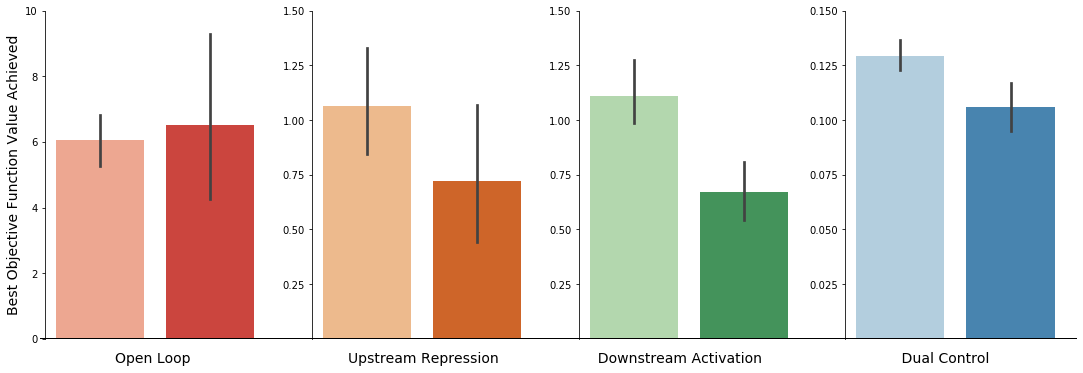

In [48]:
#Read in and merge data
exp1 = pd.read_csv('kinetic_perturbation_4arch2.csv')
exp2 = pd.read_csv('kinetic_perturbation_4arch_backup.csv')

total_perturbs = pd.concat([exp1, exp2])
total_background = pd.read_csv('background_4arch_backup.csv')
plot_background = total_background.loc[total_background['Unnamed: 0'] == 999]
plot_landscape = total_perturbs.loc[total_perturbs['Unnamed: 0'] == 999]

In [ ]:
print('PERTURBED')
print(plot_landscape.groupby('best_loss_circuit').count().loss)
print('BACKGROUND')
print(plot_background.groupby('best_loss_circuit').count().loss)

### Figure: Stacked bar of best architectures achieved
background = [83, 10, 0, 8]
singlecolors = ['blue', 'green', 'red' 'orange']
landscape = [846, 96, 18, 40]
x = ['Background', 'Perturbed']
plot_df = pd.DataFrame({'Background':background, 'Perturbed':landscape})

bottom_sum = [0, 0]
fig, ax = plt.subplots(1, 1,figsize=(7, 7))
for i in range(len(plot_df)):
    ax.bar(x, [plot_df.Background[i], plot_df.Perturbed[i]/10], bottom = bottom_sum)
    bottom_sum[0] = bottom_sum[0] + plot_df.Background[i]
    bottom_sum[1] = bottom_sum[1] + plot_df.Perturbed[i]/10

ax.set_xticklabels(x, fontsize=24)
ax.set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=24)
ax.set_ylabel('% of Optimal \n Architectures', fontsize=28)

In [ ]:
### Figure: Mean loss by architecture
fig, axs = plt.subplots(1,4,figsize=(15, 5))
palettes = ['Reds', 'Oranges', 'Greens', 'Blues']

for i in range(4):
    c = orders[i]
    da_background = total_background.loc[total_background.Circuit == c].loc[total_background['index'] == 999]
    da_landscape =  plot_landscape.loc[plot_landscape.Circuit == c]

    plot_data = pd.DataFrame({'best_loss': da_landscape.best_losses.to_list(), 'type':'Perturbed'})
    plot_data = pd.concat([plot_data, pd.DataFrame({'best_loss':da_background.best_losses.to_list(), 'type':'Background' })])
    
    ax = axs[i]
    sns.barplot(data=plot_data, y='best_loss', x='type', palette=palettes[i], ax=ax)
    ax.set_ylabel('Best Objective Function Value Achieved', fontsize=14)
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelsize=24)

    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])

    if i != 0:  
        ax.set_ylabel('')

axs[0].set_yticks([0, 2, 4, 6, 8, 10])
axs[1].set_yticks([0.25, 0.5, 0.75, 1.0, 1.25, 1.5])
axs[2].set_yticks([0.25, 0.5, 0.75, 1.0, 1.25, 1.5])
axs[3].set_yticks([0.025, 0.05, 0.075, 0.1, 0.125, 0.15])

fig.text(0.11, -0.02, 'Open Loop                                   Upstream Repression                      Downstream Activation                               Dual Control', ha='left', fontsize=14)
fig.add_artist(Line2D([0.04, 1], [0.05, 0.05], color='k', linewidth=1))

fig.tight_layout()
fig.savefig('kinetic_perturbation_loss_bar.png', dpi=300, pad_inches=1)

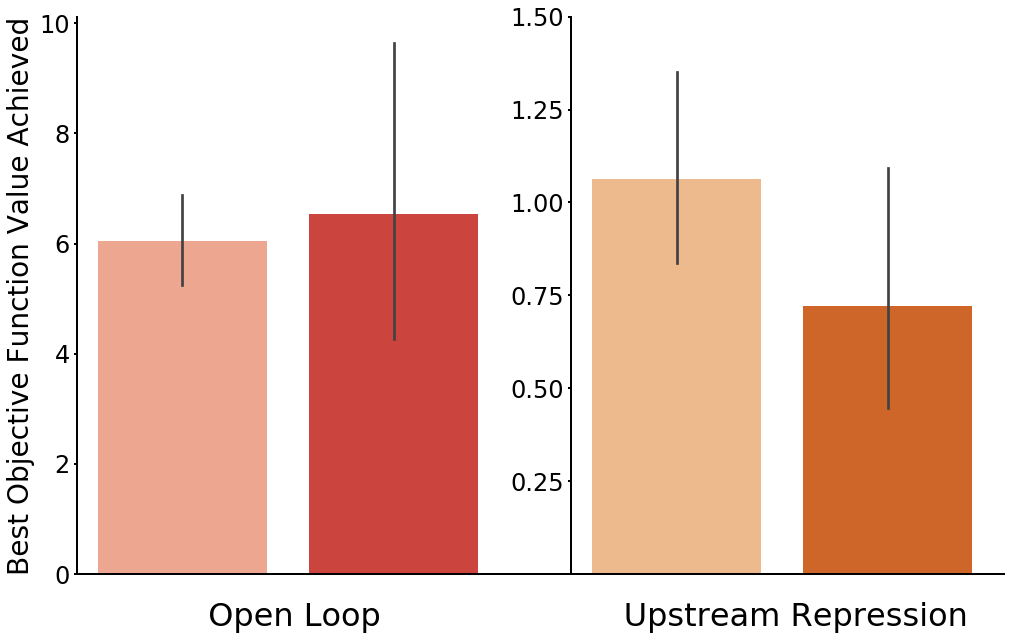

In [52]:
### Figure: Mean loss by architecture - POSTER VERSION
fig, axs = plt.subplots(1,2,figsize=(14, 9))
palettes = ['Reds', 'Oranges', 'Greens', 'Blues']

for i in range(2):
    c = orders[i]
    da_background = total_background.loc[total_background.Circuit == c].loc[total_background['index'] == 999]
    da_landscape =  plot_landscape.loc[plot_landscape.Circuit == c]

    plot_data = pd.DataFrame({'best_loss': da_landscape.best_losses.to_list(), 'type':'Perturbed'})
    plot_data = pd.concat([plot_data, pd.DataFrame({'best_loss':da_background.best_losses.to_list(), 'type':'Background' })])
    
    ax = axs[i]
    sns.barplot(data=plot_data, y='best_loss', x='type', palette=palettes[i], ax=ax)
    ax.set_ylabel('Best Objective Function Value Achieved', fontsize=28)
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelsize=14)

    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])

    ax.tick_params(axis='y', labelsize=24)
    ax.tick_params(axis='x', labelsize=24)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    ax.tick_params(width=2)

    if i != 0:  
        ax.set_ylabel('')

axs[0].set_yticks([0, 2, 4, 6, 8, 10])
axs[1].set_yticks([0.25, 0.5, 0.75, 1.0, 1.25, 1.5])
# axs[2].set_yticks([0.25, 0.5, 0.75, 1.0, 1.25, 1.5])
# axs[3].set_yticks([0.025, 0.05, 0.075, 0.1, 0.125, 0.15])

fig.text(0.11, -0.01, '          Open Loop                        Upstream Repression ', ha='left', fontsize=32)
fig.add_artist(Line2D([0.08, 1], [0.07, 0.07], color='k', linewidth=2))



fig.tight_layout()
fig.savefig('kinetic_perturbation_loss_bar_A.png', bbox_inches='tight', pad_inches=0.5)

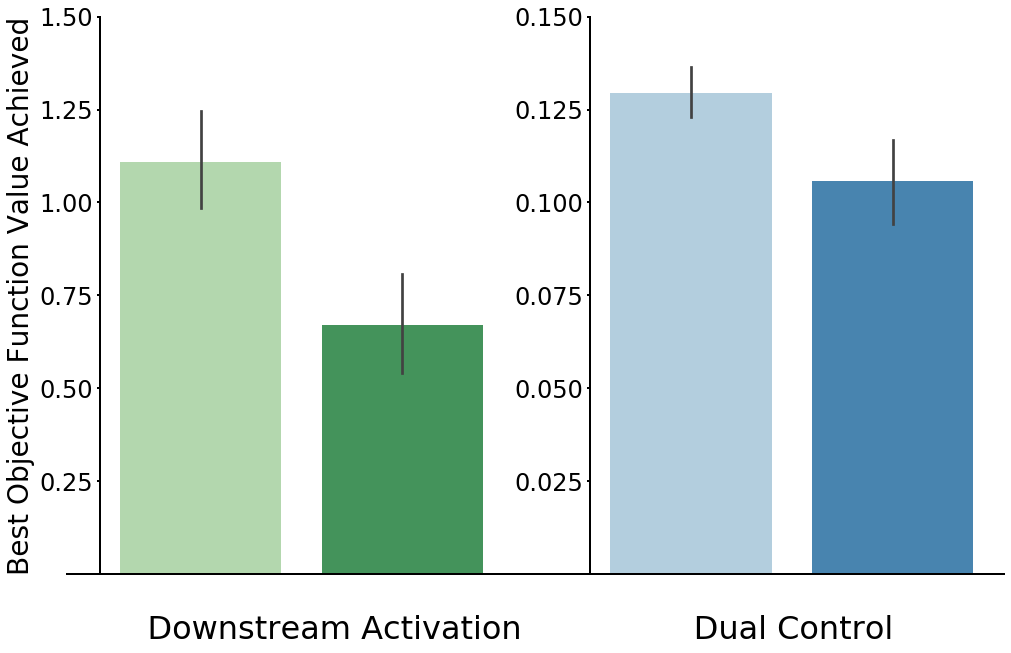

In [64]:
### Figure: Mean loss by architecture - POSTER VERSION
fig, axs = plt.subplots(1,2,figsize=(14, 9))
palettes = ['Reds', 'Oranges', 'Greens', 'Blues']

for i in [2,3]:
    c = orders[i]
    da_background = total_background.loc[total_background.Circuit == c].loc[total_background['index'] == 999]
    da_landscape =  plot_landscape.loc[plot_landscape.Circuit == c]

    plot_data = pd.DataFrame({'best_loss': da_landscape.best_losses.to_list(), 'type':'Perturbed'})
    plot_data = pd.concat([plot_data, pd.DataFrame({'best_loss':da_background.best_losses.to_list(), 'type':'Background' })])
    
    ax = axs[i-2]
    sns.barplot(data=plot_data, y='best_loss', x='type', palette=palettes[i], ax=ax)
    ax.set_ylabel('Best Objective Function Value Achieved', fontsize=28)
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelsize=14)

    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])

    ax.tick_params(axis='y', labelsize=24)
    ax.tick_params(axis='x', labelsize=24)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    ax.tick_params(width=2)

    if i != 2:  
        ax.set_ylabel('')

# axs[0].set_yticks([0, 2, 4, 6, 8, 10])
# axs[1].set_yticks([0.25, 0.5, 0.75, 1.0, 1.25, 1.5])
axs[0].set_yticks([0.25, 0.5, 0.75, 1.0, 1.25, 1.5])
axs[1].set_yticks([0.025, 0.05, 0.075, 0.1, 0.125, 0.15])

fig.text(0.11, -0.03, '    Downstream Activation                 Dual Control', ha='left', fontsize=32)
fig.add_artist(Line2D([0.07, 1], [0.07, 0.07], color='k', linewidth=2))

fig.tight_layout()
fig.savefig('kinetic_perturbation_loss_bar_B.png', dpi=300,  bbox_inches='tight', pad_inches=0.5)

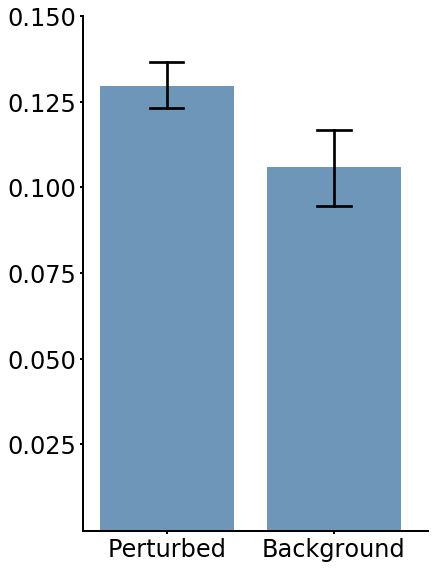

In [44]:
### Figure: Mean loss by architecture - POSTER VERSION
fig, axs = plt.subplots(1,1,figsize=(6, 8))
palettes = ['Reds', 'Oranges', 'Greens', 'Blues']
color1= (96/255,151/255, 198/255) 
color2 = (22/255,56/255,104/255)

for i in [3]:
    c = orders[i]
    da_background = total_background.loc[total_background.Circuit == c].loc[total_background['index'] == 999]
    da_landscape =  plot_landscape.loc[plot_landscape.Circuit == c]

    plot_data = pd.DataFrame({'best_loss': da_landscape.best_losses.to_list(), 'type':'Perturbed'})
    plot_data = pd.concat([plot_data, pd.DataFrame({'best_loss':da_background.best_losses.to_list(), 'type':'Background' })])
    
    ax = axs
    sns.barplot(data=plot_data, y='best_loss', x='type', color=color1, ax=ax, capsize=.2, errcolor='Black')
    ax.set_ylabel('Best Objective Function Value Achieved', fontsize=28)
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelsize=14)

    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


    ax.tick_params(axis='y', labelsize=24)
    ax.tick_params(axis='x', labelsize=24)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    ax.tick_params(width=2)

    if i != 2:  
        ax.set_ylabel('')

# axs[0].set_yticks([0, 2, 4, 6, 8, 10])
# axs[1].set_yticks([0.25, 0.5, 0.75, 1.0, 1.25, 1.5])
axs.set_yticks([0.025, 0.05, 0.075, 0.1, 0.125, 0.15])
ax.set_xticklabels(['Perturbed', 'Background'])
fig.add_artist(Line2D([0.2, 1], [0.07, 0.07], color='k', linewidth=2))

fig.tight_layout()
fig.savefig('kinetic_perturbation_loss_bar_dc_only.png', dpi=300,  bbox_inches='tight', pad_inches=0.5)

In [ ]:
### Figure: Box plots of parameter values 
fig, axs = plt.subplots(2,4,figsize=(12, 6), sharey='row')
palettes = ['Reds', 'Oranges', 'Greens', 'Blues']
params = ['k1', 'theta1', 'k2', 'theta2']
param_names = ['$k_1$', r'$\theta_1$', '$k_2$', r'$\theta_2$']
for i in range(4):
    c = orders[i]
    background = total_background.loc[total_background.Circuit == c].loc[total_background['index'] == 999]
    landscape =  plot_landscape.loc[plot_landscape.Circuit == c]
    plot_data = pd.concat([pd.DataFrame({'param':landscape.k1.to_list(), 'type':'Perturbed', 'name': param_names[0]}), pd.DataFrame({'param': landscape.theta1.to_list(), 'type':'Perturbed', 'name': param_names[1]}), pd.DataFrame({'param': landscape.k2.to_list(), 'type':'Perturbed', 'name': param_names[2]}), pd.DataFrame({'param': landscape.theta2.to_list(), 'type':'Perturbed', 'name': param_names[3]})])
    plot_background = pd.concat([pd.DataFrame({'param':background.k1.to_list(), 'type':'Background', 'name': param_names[0]}), pd.DataFrame({'param': background.theta1.to_list(), 'type':'Background', 'name': param_names[1]}), pd.DataFrame({'param': background.k2.to_list(), 'type':'Background', 'name': param_names[2]}), pd.DataFrame({'param': background.theta2.to_list(), 'type':'Background', 'name': param_names[3]})])
    plot_data = pd.concat([plot_data, plot_background])

    for j in range(2):
        if j == 0:
            subset = plot_data.loc[plot_data.name.isin([param_names[0], param_names[2]])]
        else:
            subset = plot_data.loc[plot_data.name.isin([param_names[1], param_names[3]])] 
        ax = axs[j][i]
        sns.boxplot(data=subset, y='param', x='name', hue='type', palette=palettes[i], ax=ax, dodge=True)
        ax.legend([], [], frameon=False)
        ax.set_ylabel(param_names[i], fontsize=14)
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelsize=14)

        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        if i != 0: 
            ax.spines['left'].set_visible(False) 
            ax.set_ylabel('')
            axs[j][i].tick_params(axis='y', which='both',left=False)
        if j == 0:
            axs[j][i].tick_params(axis='x', which='both',bottom=False)
axs[0][0].set_ylabel('K values', fontsize=14)
axs[1][0].set_ylabel(r'$\theta$ values', fontsize=14)
fig.add_artist(Line2D([0.058, 1], [0.09, 0.09], color='k', linewidth=1))
fig.add_artist(Line2D([0.057, 1], [0.56, 0.56], color='k', linewidth=1))
axs[0][0].set_yticks([0,2, 4, 6])
axs[0][0].set_ylim([-0.1, 6])

fig.tight_layout()
fig.savefig('kinetic_perturbation_param_box.png', dpi=300)

In [65]:
## Run PCA and T-SNE
features = ['k1', 'k2', 'theta1', 'theta2']
background = total_background.loc[total_background['index'] == 999]
background['perturbed'] = [False for i in range(len(background))]
perturbed = plot_landscape
perturbed['perturbed'] =  [True for i in range(len(perturbed))]
combined = pd.concat([background, perturbed])
x = combined.loc[:, features].values
#Normalize features
x = StandardScaler().fit_transform(x)
#Run PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])
combined['pc1'] = principalComponents[:,0]
combined['pc2'] = principalComponents[:,1]

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, init='pca')
tsne_results = tsne.fit_transform(x)
combined['tsne1'] = tsne_results[:,0]
combined['tsne2'] = tsne_results[:,1]

perturbed = combined.loc[combined.perturbed == True].sort_values(by='Circuit').reset_index(drop=True)
background = combined.loc[combined.perturbed == False].sort_values(by='Circuit').reset_index(drop=True)

/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_11830/1784704547.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  background['perturbed'] = [False for i in range(len(background))]
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_11830/1784704547.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perturbed['perturbed'] =  [True for i in range(len(perturbed))]
/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The de

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2398 samples in 0.007s...
[t-SNE] Computed neighbors for 2398 samples in 0.060s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2398
[t-SNE] Computed conditional probabilities for sample 2000 / 2398
[t-SNE] Computed conditional probabilities for sample 2398 / 2398
[t-SNE] Mean sigma: 0.381004
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.517136
[t-SNE] KL divergence after 300 iterations: 1.285683


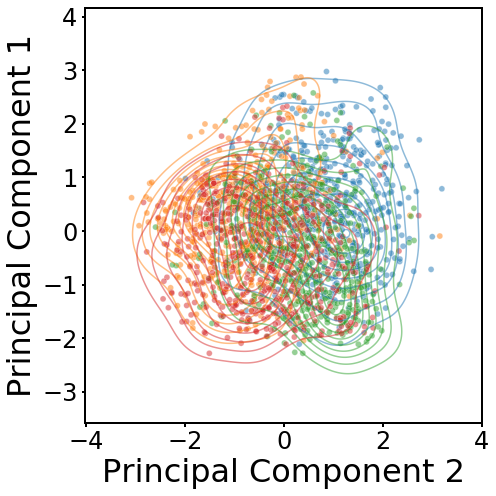

In [71]:
### Figure: PCA results
fig, axs = plt.subplots(1,1,figsize=(7,7))
ax = axs
sns.scatterplot(x="pc1", y="pc2", data=perturbed, hue='Circuit', ax=ax, legend=False, alpha=0.5)
sns.kdeplot(data=background, x="pc1", y="pc2", hue="Circuit", thresh=.1, ax=ax, alpha=0.5, legend=False)
ax.set_ylabel('Principal Component 1', fontsize=32)
ax.set_xlabel('Principal Component 2', fontsize=32)
ax.tick_params(axis='y', labelsize=24)
ax.tick_params(axis='x', labelsize=24)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(width=2)

fig.tight_layout()
fig.savefig('kinetic_perturbation_pca.png', dpi=300)

#### Growth Condition Robustness

In [ ]:
background = total_background.loc[total_background['index'] == 999]
influx = pd.read_csv('gc_influx_total.csv')
influx = influx.loc[influx['index'] == 999]
export = pd.read_csv('gc_export_total.csv')
export = export.loc[export['index'] == 999]

In [ ]:
plt.imshow([[ (0.30196078431372547, 0.6862745098039216, 0.2901960784313726)]])

In [ ]:
### Figure: Influx scan
archs = ['Downstream Activation', 'Dual Control', 'Open Loop', 'Upstream Repression' ]
colors = [ (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745), (1.0, 0.4980392156862745, 0.0)]

export['scaledperturb']= 100*(export.perturbation - 1)/1
influx['scaledperturb']= 100*(influx.perturbation - 1)/1
influx = influx.sort_values(by='Circuit')
export = export.sort_values(by='Circuit')

fig, axs = plt.subplots(1,2,figsize=(10, 5), sharey=True)
for i in range(4):
    ax = axs[0]
    sns.regplot(data=influx.loc[influx.Circuit == archs[i]], x="scaledperturb", y="best_losses", ax=ax, 
                ci=None, order=1, color=colors[i], robust=True, scatter_kws={'alpha':0.5})
    ax.set_yscale('log')
    ax.set_ylabel('Objective Function Value', fontsize=14)
    ax.set_xlabel('Perturbation Size, %', fontsize=14)

    ax = axs[1]
    sns.regplot(data=export.loc[export.Circuit == archs[i]], x="scaledperturb", y="best_losses",  ax=ax, 
                ci=None, order=1, color=colors[i], robust=True, scatter_kws={'alpha':0.5})
    ax.set_yscale('log')
    ax.set_ylabel('')
    ax.set_xlabel('Perturbation Size, %', fontsize=14)

fig.tight_layout()
fig.savefig('growth_condition_robustness.png', dpi=300)

### Single architecture visualization

In [50]:
dc_perturbed = plot_landscape.loc[plot_landscape.Circuit == 'Dual Control'].loc[total_background['index'] == 999].reset_index(drop=True)
dc_background = total_background.loc[total_background.Circuit == 'Dual Control'].loc[total_background['index'] == 999].reset_index(drop=True)

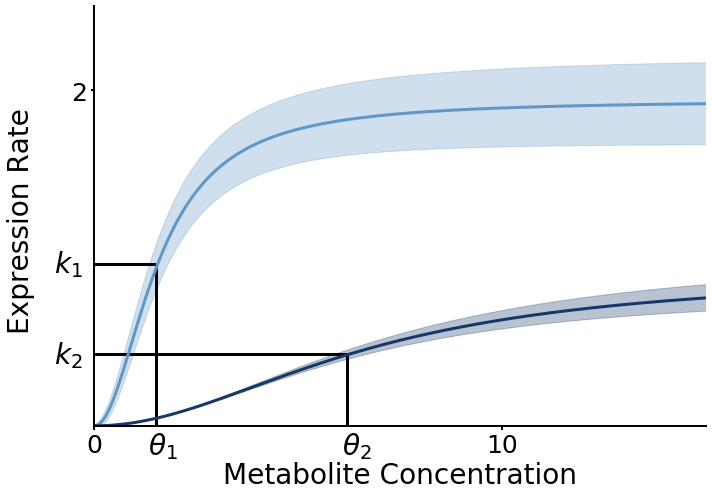

In [16]:
#Dose response curves
color1= (96/255,151/255, 198/255) 
color2 = (22/255,56/255,104/255)

xs = np.arange(0, 25, 0.001)

ys = []
for i in range(100):
    ys.append(hilleqn(xs, dc_background.k1[i], 2., dc_background.theta1[i]))
ys = np.array(ys)   
ci1 = [ys[:, j].mean() * (ys[:, j].std()/np.sqrt(100)) for j in range(ys.shape[1])]
mean_y1 = hilleqn(xs, dc_background.k1.mean(), 2., dc_background.theta1.mean())

ys = []
for i in range(100):
    ys.append(hilleqn(xs, dc_background.k2[i], 2., dc_background.theta2[i]))
ys = np.array(ys)   
ci2 = [ys[:, j].mean() * (ys[:, j].std()/np.sqrt(100)) for j in range(ys.shape[1])]
mean_y2 = hilleqn(xs, dc_background.k2.mean(), 2., dc_background.theta2.mean())


x_star1 = mean_y1[-1]/2
x_star2 = mean_y2[-1]/2


fig, axs = plt.subplots(1,1,figsize=(10, 7))
ax = axs
ax.plot(xs, mean_y1, c=color1, linewidth=3)
ax.fill_between(xs, mean_y1 - ci1, mean_y1 + ci1, alpha=0.3, color=color1)

ax.plot(xs, mean_y2, c=color2, linewidth=3)
ax.fill_between(xs, mean_y2 - ci2, mean_y2 + ci2, alpha=0.3, color=color2)
ax.vlines(1.5, 0, x_star1, linewidth=3)
ax.hlines(x_star1, 0, 1.5, linewidth=3)
ax.vlines(6.2, 0, x_star2, linewidth=3)
ax.hlines(x_star2, 0, 6.2, linewidth=3)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
ax.tick_params(width=2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.set(yticks=[2], xticks=[0, 10, 20])
ax.set_ylim([0, 2.5])
ax.set_xlim([0, 15])
ax.set_ylabel('Expression Rate \n', fontsize = 28)
ax.set_xlabel('Metabolite Concentration', fontsize=28)
fig.text(0.21, 0.09, r'$\theta_1$', ha='left', fontsize=28)
fig.text(0.48, 0.09, r'$\theta_2$', ha='left', fontsize=28)
fig.text(0.08, 0.27, r'$k_2$', ha='left', fontsize=28)
fig.text(0.08, 0.45, r'$k_1$', ha='left', fontsize=28)
fig.tight_layout()
fig.savefig('dose_response_curves.png', dpi=300, bbox_inches='tight', pad_inches=0.)


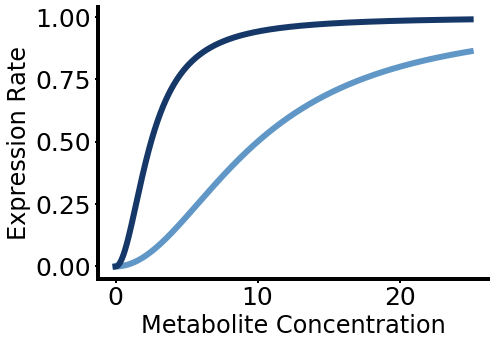

In [18]:

fig, axs = plt.subplots(1,1,figsize=(7, 5))
ax = axs
y1 = hilleqn(xs, 1., 2., 10.)
y2 = hilleqn(xs, 1., 2., 2.5)
ax.plot(xs, y1, c=color1, linewidth=6)
ax.plot(xs, y2, c=color2, linewidth=6)
for axis in ['top','right']:
   ax.spines[axis].set_linewidth(0)
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
ax.tick_params(width=2)
ax.spines['bottom'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)
ax.set_ylabel('Expression Rate', fontsize = 24)
ax.set_xlabel('Metabolite Concentration', fontsize=24)
fig.savefig('drc_k2.png', dpi=300, bbox_inches='tight', pad_inches=0.)

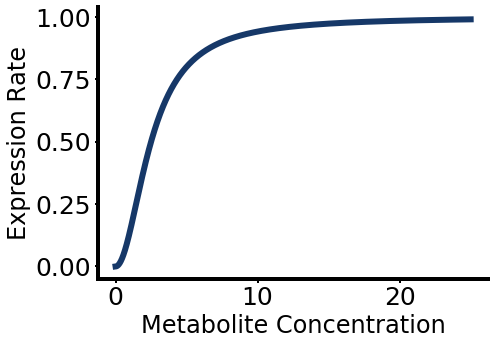

In [23]:

fig, axs = plt.subplots(1,1,figsize=(7, 5))
ax = axs
y1 = hilleqn(xs, 0.5, 2., 2.5)
y2 = hilleqn(xs, 1., 2., 2.5)
#
# 
# ax.plot(xs, y1, c=color1, linewidth=6)
ax.plot(xs, y2, c=color2, linewidth=6)
for axis in ['top','right']:
   ax.spines[axis].set_linewidth(0)
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
ax.tick_params(width=2)
ax.spines['bottom'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)
ax.set_ylabel('Expression Rate', fontsize = 24)
ax.set_xlabel('Metabolite Concentration', fontsize=24)
fig.savefig('drc_t_1.png', dpi=300, bbox_inches='tight', pad_inches=0.)

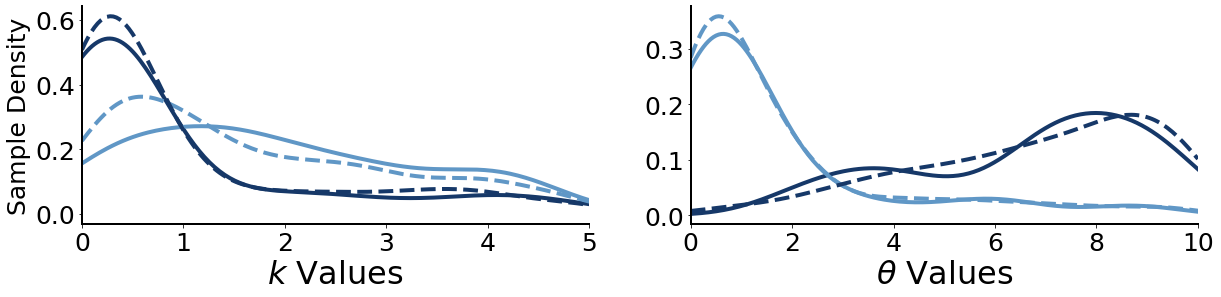

In [51]:
#Parameter distributions
fig, axs = plt.subplots(1,2,figsize=(20, 4))
ax = axs[0]
sns.kdeplot(dc_background.k2, clip=[0, 5], fill=False, color=color2, ax=ax, linewidth=4)
sns.kdeplot(dc_background.k1, clip=[0, 5], fill=False, color=color1, ax=ax, linewidth=4)
sns.kdeplot(dc_perturbed.k1, clip=[0, 10], fill=False, color=color1, ax=ax, linewidth=4, linestyle='dashed')
sns.kdeplot(dc_perturbed.k2, clip=[0, 10], fill=False, color=color2, ax=ax, linewidth=4, linestyle='dashed')

ax.set_xlim([0, 5])
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
ax.set_ylabel('Sample Density', fontsize=25)
ax.set_xlabel(r'$k$ Values', fontsize=32)

ax = axs[1]
sns.kdeplot(dc_background.theta2, clip=[0, 10], fill=False, color=color2, ax=ax, linewidth=4)
sns.kdeplot(dc_background.theta1, clip=[0, 10], fill=False, color=color1, ax=ax, linewidth=4)
sns.kdeplot(dc_perturbed.theta1, clip=[0, 10], fill=False, color=color1, ax=ax, linewidth=4, linestyle='dashed')
sns.kdeplot(dc_perturbed.theta2, clip=[0, 10], fill=False, color=color2, ax=ax, linewidth=4, linestyle='dashed')

ax.set_xlim([0, 10])
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
ax.set_ylabel('')
ax.set_xlabel(r'$\theta$ Values', fontsize=32)
fig.savefig('param_dists.png', dpi=300, bbox_inches='tight', pad_inches=0.)


In [53]:
dc_perturbed.theta2.mean()

6.796817881104948

(0, 10)

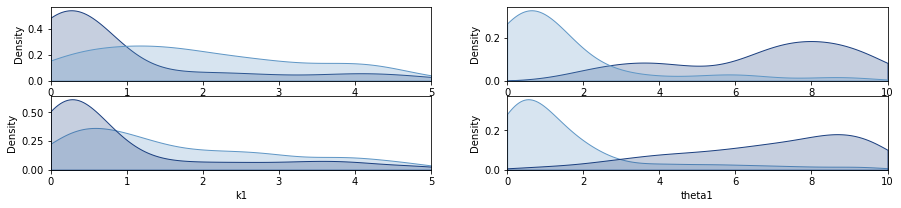

In [191]:
#Parameter distributions
fig, axs = plt.subplots(2,2,figsize=(15, 3))
ax = axs[0][0]
sns.kdeplot(dc_background.k2, clip=[0, 5], fill=True, color=color2, ax=ax)
sns.kdeplot(dc_background.k1, clip=[0, 5], fill=True, color=color1, ax=ax)
ax.set_xlim([0, 5])
ax = axs[1][0]
sns.kdeplot(dc_perturbed.k1, clip=[0, 10], fill=True, color=color1, ax=ax)
sns.kdeplot(dc_perturbed.k2, clip=[0, 10], fill=True, color=color2, ax=ax)
ax.set_xlim([0, 5])
ax = axs[0][1]
sns.kdeplot(dc_background.theta2, clip=[0, 10], fill=True, color=color2, ax=ax)
sns.kdeplot(dc_background.theta1, clip=[0, 10], fill=True, color=color1, ax=ax)
ax.set_xlim([0, 10])
ax = axs[1][1]
sns.kdeplot(dc_perturbed.theta1, clip=[0, 10], fill=True, color=color1, ax=ax)
sns.kdeplot(dc_perturbed.theta2, clip=[0, 10], fill=True, color=color2, ax=ax)
ax.set_xlim([0, 10])

In [4]:
k_var = 0.01
theta_var = 0.5
i = 0

def run_once(args):
    architecture, param_values = args
    #Integration conditions
    t = np.linspace(0, 5E5, 200) 
    y0 = np.array([0.281, 0.0605, 0., 0., 0. , 0., 0.]) #g6p, f6p, mi, ino1, miox

    extra_options = {'old_api': False, 'user_data': [architecture, param_values], 'rtol':1E-4}
    ode_solver = ode('cvode', glucaric_acid, **extra_options)
    solution = ode_solver.solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-3)
    return loss

def avg_dev(arch, start):
    circuit = total_background.loc[total_background.Circuit == name_converter(arch)].iloc[start:start+100]
    circuit = circuit.loc[circuit.best_losses != 0]
    optimal = circuit.loc[circuit.best_losses == circuit.best_losses.min()].reset_index(drop=True).iloc[0]

    circle = [run_once([arch, [[2., optimal.theta1 + theta_var, optimal.k1], [2.,optimal.theta2, optimal.k2]]]),
    run_once([arch, [[2., optimal.theta1, optimal.k1 + k_var], [2.,optimal.theta2, optimal.k2]]]),
    run_once([arch, [[2., optimal.theta1, optimal.k1], [2.,optimal.theta2 + theta_var, optimal.k2]]]),
    run_once([arch, [[2., optimal.theta1, optimal.k1], [2.,optimal.theta2, optimal.k2 + k_var]]]),
    run_once([arch, [[2., optimal.theta1 - theta_var, optimal.k1], [2.,optimal.theta2, optimal.k2]]]),
    run_once([arch, [[2., optimal.theta1, optimal.k1 - k_var], [2.,optimal.theta2, optimal.k2]]]),
    run_once([arch, [[2., optimal.theta1, optimal.k1], [2.,optimal.theta2 - theta_var, optimal.k2]]]),
    run_once([arch, [[2., optimal.theta1, optimal.k1], [2.,optimal.theta2, optimal.k2 - k_var]]])]
    if name_converter(arch) == 'No Control':
        circle = [circle[1], circle[3], circle[5], circle[7]]
        avg_dev = np.mean(circle - optimal.loss)
    elif name_converter(arch) == 'Upstream Repression':
        circle = [circle[0],circle[1], circle[2], circle[3], circle[5], circle[6], circle[7]]
        avg_dev = np.mean(circle - optimal.loss)
    elif name_converter(arch) == 'Downstream Activation':
        circle = [circle[1], circle[3],circle[4], circle[5], circle[7]]
        avg_dev = np.mean(circle - optimal.loss)
    else: avg_dev = np.mean(circle - optimal.loss)
    
    return avg_dev

In [5]:
ur_devs = [avg_dev(((0, 1, 0), (0, 0, 1)), i*1000) for i in range(100)]
da_devs = [avg_dev(((0, 0, 1), (1, 0, 0)), i*1000) for i in range(100)]
nc_devs = [avg_dev(((0, 0, 1), (0, 0, 1)), i*1000) for i in range(100)]
dc_devs = [avg_dev(((0, 1, 0), (1, 0, 0)), i*1000) for i in range(100)]


[CVODE WARNING]  CVode
  Internal t = 177.004 and h = 1.4143e-14 are such that t + h = t on the next step. The solver will continue anyway.

/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_36329/1267096309.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  vm_eff = vm * (1+ (a*x)/(ka + x))
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_36329/1267096309.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return (vm*(x - (y/keq)))/(x + kmx*(1+(y/kmy)))
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_36329/1267096309.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (vm*x)/(km+x)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_36329/1267096309.py:13: RuntimeWarning: invalid value encountered in double_scalars
  return (vm*x**n)/(km**n + x**n)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_36329/1267096309.py:16: RuntimeWarning: invalid value encountered in double_scalars


In [6]:
def opt_loss(arch, start):
    circuit = total_background.loc[total_background.Circuit == name_converter(arch)].iloc[start:start+100]
    circuit = circuit.loc[circuit.best_losses != 0]
    optimal = circuit.loc[circuit.best_losses == circuit.best_losses.min()].reset_index(drop=True).iloc[0]
    return optimal.loss

ur_loss = [opt_loss(((0, 1, 0), (0, 0, 1)), i*1000) for i in range(100)]
da_loss = [opt_loss(((0, 0, 1), (1, 0, 0)), i*1000) for i in range(100)]
nc_loss = [opt_loss(((0, 0, 1), (0, 0, 1)), i*1000) for i in range(100)]
dc_loss = [opt_loss(((0, 1, 0), (1, 0, 0)), i*1000) for i in range(100)]

Text(0.5, 0, 'Optimality')

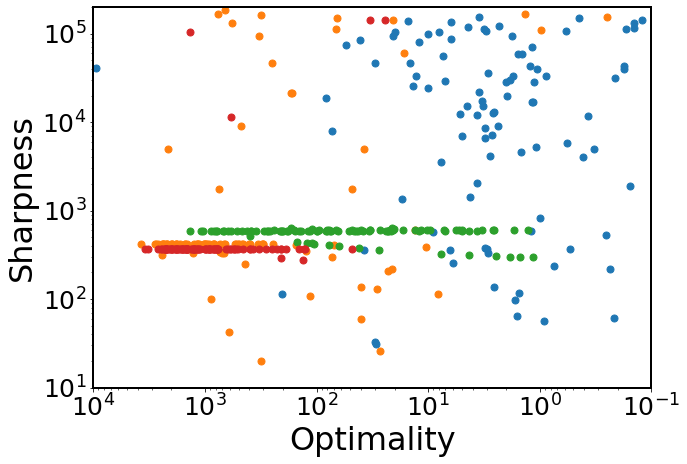

In [31]:
fig, axs = plt.subplots(1,1,figsize=(10, 7))
ax = axs
ax.plot(dc_loss, dc_devs, 'o', markersize=7)
ax.plot(ur_loss, ur_devs, 'o', markersize=7)
ax.plot(da_loss, da_devs, 'o', markersize=7)
ax.plot(nc_loss, nc_devs, 'o', markersize=7)
ax.set_yscale('log')
ax.set_ylim([10, 200000])
ax.set_xlim([10E3, 10E-2])
ax.set_xscale('log')
for axis in ['top','right', 'bottom', 'left']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
ax.set_ylabel('Sharpness', fontsize=32)
ax.set_xlabel('Optimality', fontsize=32)

In [286]:
plot_data = pd.DataFrame({'loss':ur_loss, 'dev':ur_devs, 'circuit':'Upstream Repression'})
plot_data = pd.concat([plot_data, pd.DataFrame({'loss':dc_loss, 'dev':dc_devs, 'circuit':'Dual Control'})])
plot_data = pd.concat([plot_data, pd.DataFrame({'loss':da_loss, 'dev':da_devs, 'circuit':'Downstream Activation'})])
plot_data = pd.concat([plot_data, pd.DataFrame({'loss':nc_loss, 'dev':nc_devs, 'circuit':'Open Loop'})])

/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


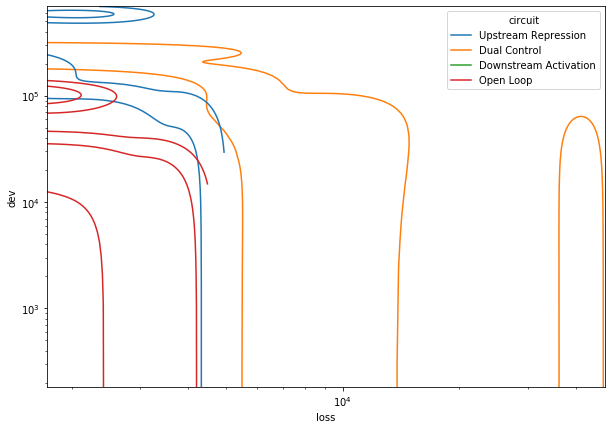

In [325]:
fig, axs = plt.subplots(1,1,figsize=(10, 7))
ax = axs
sns.kdeplot(data=plot_data.reset_index(drop=True), x="loss", y='dev', hue='circuit',levels=10,thresh=1E-5, ax=ax)
sns.kdeplot(data=plot_data.reset_index(drop=True), x="loss", y='dev', hue='circuit',levels=10,thresh=1E-3, ax=ax)
sns.kdeplot(data=plot_data.reset_index(drop=True), x="loss", y='dev', hue='circuit',levels=10,thresh=1E-7, ax=ax)

ax.set_xscale('log')
ax.set_yscale('log')